# Objetive

- Create a model to predict delinquency probability and measure its performance.
- Submit a document that explains your methodology - preferably ipython notebooks

# Datasets
You will find 3 csv files. The files were created from our database as of 2020 Feb 05.

#####      *Brazil_DS_loans_2019-11-10_2019-12-05*

It has the loans made for a period of 25 days with following important fields

- Loan_id - unique identifier for a loan
- Uuid - user identifier
- Created_at - time when loan was created
- Paid_at - time when it was paid. If it is missing then loan was not paid as of file creation date
- Amount - amount of loan

A
 loan is considered repaid if it's paid within 60 days.The objective is 
to create a predictive model for loan repayment based on the labels in 
this file.

#####       *Brazil_DS_prev_loans*

This has the previous loans taken for users in the above file and should have the same schema.

#####       *Brazil_DS_recharges_2019-08-10_2019-12-05*

A user pays for loans by making recharges after taking a loan. This file contains recharges for all users for about 4 months.

#### Read

Datasets Brazil_DS_loans_2019-11-10_2019-12-05 and Brazil_DS_prev_loans were concatenated

In [3]:
from functions.read import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from functions.feature_default import ForecastDefault
import logging
import warnings

warnings.filterwarnings("ignore")
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
loans, recharges = load_dfs()

In [4]:
#run to load some metrics to exploratory
forecast = ForecastDefault(
    loans_hist=loans, 
    recharges_hist=recharges, estimators_list=[
                                                LogisticRegression,
                                                XGBClassifier,
                                                RandomForestClassifier,
                                                ],
    eval_metric='roc_auc',
    inicial_date='2019-01-01',days_to_default=60,limit_date='2019-12-31')

# Report

#### Exploratory data analysis

In [5]:
#forecast.train_df.groupby('target').count()['uuid'].to_frame() / len(forecast.train_df)

The analysis date range is between *2019-01-16* - *2019-12-04*. The timeline for creating the model training dataset has a deadline up to *2019-10-05* which corresponds to 60 days before the last creation date of the loans. The target variable, customers who have not paid their loans within 60 days, has a prevalence of only 11%.

| Default | Relative % |
|---------|------------|
| Not     | 88.4%      |
| Yes     | 11.5%      |


Summary values distribution over each variable. 

In [6]:
(forecast.train_df.describe(),pd.DataFrame({'Median':forecast.train_df.median()}))

(            target  median_amount_loan  freq_recharges_weekly  \
 count  1033.000000         1033.000000            1033.000000   
 mean      0.115198            4.658761               0.956559   
 std       0.319416            1.404576               0.824489   
 min       0.000000            0.000000               0.000000   
 25%       0.000000            5.000000               0.375000   
 50%       0.000000            5.000000               0.750000   
 75%       0.000000            5.000000               1.250000   
 max       1.000000           10.000000               5.500000   
 
        recharges_weekly  delta_after_recharges  
 count       1033.000000            1033.000000  
 mean           0.170196               0.541723  
 std            0.087977               0.964410  
 min            0.000000               0.000000  
 25%            0.125000               0.075000  
 50%            0.125000               0.285000  
 75%            0.250000               0.670000  
 max

The variables *median_amount_loan*, *delta_after_recharges* and *recharges_weekly* have a heavy tail so it was preferred to use median over mean to group each UUID.

'recharges_weekly AxesSubplot(0.125,0.125;0.775x0.755)'

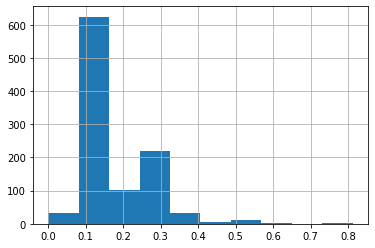

In [7]:
(f"recharges_weekly {forecast.train_df['recharges_weekly'].hist()}")

<AxesSubplot:>

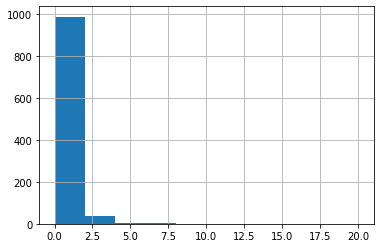

In [8]:
forecast.train_df['delta_after_recharges'].hist()

<AxesSubplot:>

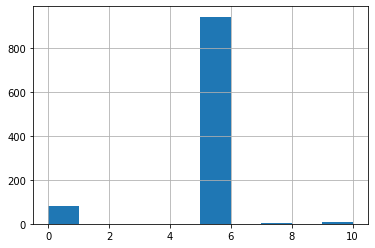

In [9]:
forecast.train_df['median_amount_loan'].hist()

##### Created variables

Data were grouped for each *UUID*

    
    already_default =   0 if not defaulted, 1 if defaulted
    median_amoun_loan =  "median amount of all previous loans paid"
    count_loans =  "number of previous loans paid"
    freq_recharges_weekly =  "mean frequency recharges per week"
    recharges_weekly =  "median frequency recharges per week"
    delta_after_recharge =  "difference between balance after recharge and recharge value"
    



The variable *count_loans* was removed because have multicolinearity with the variables *sum_amount* over 95%.

In [10]:
forecast.corr_df.corr()

,target,median_amount_loan,count_loans,freq_recharges_weekly,recharges_weekly,delta_after_recharges
target,1.000000,-0.021494,-0.061411,-0.237355,-0.085627,-0.054256
median_amount_loan,-0.021494,1.000000,0.440354,0.370435,0.352840,0.051462
count_loans,-0.061411,0.440354,1.000000,0.609952,0.449434,0.071755
freq_recharges_weekly,-0.237355,0.370435,0.609952,1.000000,0.697400,0.065405
recharges_weekly,-0.085627,0.352840,0.449434,0.697400,1.000000,0.097317
delta_after_recharges,-0.054256,0.051462,0.071755,0.065405,0.097317,1.000000


The training dataset was balanced by undersampling the majority class resulting in the shape

In [11]:
print(f"Target distribution before sampling \n {forecast.train_df['target'].value_counts()} \n \n 'Target distribution after undersampling \n {forecast.model.train_y.value_counts()}")

Target distribution before sampling 
 0    914
1    119
Name: target, dtype: int64 
 
 'Target distribution after undersampling 
 0    119
1    119
Name: target, dtype: int64


In [12]:
print(f'Train dataset shape. Row: {forecast.model.train_X.shape[0]}, Columns: {forecast.model.train_X.shape[1]}')

Train dataset shape. Row: 238, Columns: 4


## Fit model and hyphotesis cases

The model was trained splitting in folds to select the best model to the evaluation metric. The models picked were [*XGboost*, *Random Forest*, *Logistic Regression*]. Differents hyphotesis were created.

#### 1 - If the model's target is to primarily detect the delinquencies. The evaluation metric should be *recall*

The *XGBClassifier* should be chosen with the mean performance metric = 0.64

In [13]:
logger.setLevel(logging.INFO)
forecast = ForecastDefault(
    loans_hist=loans, 
    recharges_hist=recharges, estimators_list=[
                                                LogisticRegression,
                                                XGBClassifier,
                                                RandomForestClassifier,
                                                ],
    eval_metric='recall',
    inicial_date='2019-01-01',days_to_default=60,limit_date='2019-12-31')

INFO:root:<class 'sklearn.linear_model._logistic.LogisticRegression'> : Training sample metrics | [0.783, 0.52, 0.826, 0.739, 0.56] | mean: 0.686
INFO:root:<class 'xgboost.sklearn.XGBClassifier'> : Training sample metrics | [0.826, 0.72, 0.87, 0.913, 0.8] | mean: 0.826
INFO:root:<class 'sklearn.ensemble._forest.RandomForestClassifier'> : Training sample metrics | [0.826, 0.64, 0.87, 0.913, 0.76] | mean: 0.802
INFO:root:Best model :XGBClassifier
INFO:root:Test sampling recall : 0.647
INFO:root:Classification report 
               precision    recall  f1-score   support

           0       0.85      0.53      0.65       187
           1       0.27      0.65      0.38        51

    accuracy                           0.55       238
   macro avg       0.56      0.59      0.52       238
weighted avg       0.72      0.55      0.59       238

INFO:root:Confusion matrix 
 [[99 88]
 [18 33]]


#### 2 - If the model's target is to primarily not miss at all. The evaluation metric should be *Accuracy*

The *Random Forest* should be chosen with the mean performance metric = 0.55

In [14]:
logger.setLevel(logging.INFO)
forecast = ForecastDefault(
    loans_hist=loans, 
    recharges_hist=recharges, estimators_list=[
                                                LogisticRegression,
                                                XGBClassifier,
                                                RandomForestClassifier,
                                                ],
    eval_metric='acc',
    inicial_date='2019-01-01',days_to_default=60,limit_date='2019-12-31')

INFO:root:<class 'sklearn.linear_model._logistic.LogisticRegression'> : Training sample metrics | [0.896, 0.75, 0.917, 0.872, 0.766] | mean: 0.84
INFO:root:<class 'xgboost.sklearn.XGBClassifier'> : Training sample metrics | [0.812, 0.792, 0.875, 0.872, 0.851] | mean: 0.84
INFO:root:<class 'sklearn.ensemble._forest.RandomForestClassifier'> : Training sample metrics | [0.875, 0.792, 0.854, 0.894, 0.83] | mean: 0.849
INFO:root:Best model :RandomForestClassifier
INFO:root:Test sampling acc : 0.559
INFO:root:Classification report 
               precision    recall  f1-score   support

           0       0.85      0.53      0.66       187
           1       0.28      0.65      0.39        51

    accuracy                           0.56       238
   macro avg       0.56      0.59      0.52       238
weighted avg       0.72      0.56      0.60       238

INFO:root:Confusion matrix 
 [[100  87]
 [ 18  33]]


#### 3 - If the model's target is to primarily balance between precision and detect correctly delinquencies. The evaluation metric should be *F-1*

The *Random Forest* should be chosen with the mean performance metric = 0.38

In [15]:
logger.setLevel(logging.INFO)
forecast = ForecastDefault(
    loans_hist=loans, 
    recharges_hist=recharges, estimators_list=[
                                                LogisticRegression,
                                                XGBClassifier,
                                                RandomForestClassifier,
                                                ],
    eval_metric='f1',
    inicial_date='2019-01-01',days_to_default=60,limit_date='2019-12-31')

INFO:root:<class 'sklearn.linear_model._logistic.LogisticRegression'> : Training sample metrics | [0.878, 0.684, 0.905, 0.85, 0.718] | mean: 0.807
INFO:root:<class 'xgboost.sklearn.XGBClassifier'> : Training sample metrics | [0.809, 0.783, 0.87, 0.875, 0.851] | mean: 0.838
INFO:root:<class 'sklearn.ensemble._forest.RandomForestClassifier'> : Training sample metrics | [0.864, 0.791, 0.851, 0.917, 0.826] | mean: 0.85
INFO:root:Best model :RandomForestClassifier
INFO:root:Test sampling f1 : 0.382
INFO:root:Classification report 
               precision    recall  f1-score   support

           0       0.84      0.52      0.65       187
           1       0.27      0.65      0.38        51

    accuracy                           0.55       238
   macro avg       0.56      0.59      0.51       238
weighted avg       0.72      0.55      0.59       238

INFO:root:Confusion matrix 
 [[98 89]
 [18 33]]


#### 4 - If the purpose of the model is primarily to distinguish the classes. The evaluation metric should be *AUC*

The *Random Forest* should be chosen with the mean performance metric = 0.58

In [16]:
forecast = ForecastDefault(
    loans_hist=loans, 
    recharges_hist=recharges, estimators_list=[
                                                LogisticRegression,
                                                XGBClassifier,
                                                RandomForestClassifier,
                                                ],
    eval_metric='roc_auc',
    inicial_date='2019-01-01',days_to_default=60,limit_date='2019-12-31')

INFO:root:<class 'sklearn.linear_model._logistic.LogisticRegression'> : Training sample metrics | [0.891, 0.76, 0.913, 0.87, 0.78] | mean: 0.843
INFO:root:<class 'xgboost.sklearn.XGBClassifier'> : Training sample metrics | [0.813, 0.795, 0.875, 0.873, 0.855] | mean: 0.842
INFO:root:<class 'sklearn.ensemble._forest.RandomForestClassifier'> : Training sample metrics | [0.833, 0.818, 0.855, 0.894, 0.835] | mean: 0.847
INFO:root:Best model :RandomForestClassifier
INFO:root:Test sampling roc_auc : 0.591
INFO:root:Classification report 
               precision    recall  f1-score   support

           0       0.85      0.53      0.66       187
           1       0.28      0.65      0.39        51

    accuracy                           0.56       238
   macro avg       0.56      0.59      0.52       238
weighted avg       0.72      0.56      0.60       238

INFO:root:Confusion matrix 
 [[100  87]
 [ 18  33]]


## Future improvements

Creating allowed loans limits to each costumer combining regression models with business stategy to simulate different scenarios and evaluate possible Return On Investiment for each strategy. Once chosen the strategy we could test it using A/B tests